# 自编码器简介


## 监督学习与无监督学习


### 监督学习


在之前的课程中，我们仅讨论了监督学习的情况。简单来说，监督学习是指训练数据同时包含输入 **x** 和输出 **y** 的情况。模型需要以 **x** 作为输入并预测 **y**。
例如，在 MNIST 数据集中，我们有一个图像 **x** 和一个标签 **y**（表示 0 到 9 之间的数字）。在图像分割中，我们使用一个图像 **x** 和一个分割掩码 **y** 作为输出。


### 无监督学习


在无监督学习中，数据没有标签，这意味着我们只有 **x** 而没有 **y**。在这种情况下，我们无法预测精确的值，但可以训练模型将相似的元素进行分组（称为聚类）。
在本课程中，我们将重点讨论无监督异常检测。其核心思想是：训练一个模型使其适应某一类型的数据，然后用它来检测与训练集不同的元素。


## 自编码器


### 架构


用于这类任务的基础模型称为“自编码器”。其架构与我们之前学习的 U-Net 类似。
以下是经典自编码器的架构：


如你所见，它的形状类似于“沙漏”。自编码器的核心思想是：将输入数据压缩为低维表示，然后从该表示中重建数据。此外，这种模型还可以用于数据压缩。


### 用于无监督异常检测


在无监督异常检测中，我们以一个例子来说明。假设我们训练自编码器重建数字“5”的图像。训练完成后，它能够完美重建“5”的图像。如果想检测一张图像是“5”还是其他数字，只需将其输入自编码器。通过分析重建质量（$image_{原始} - image_{重建}$），我们可以判断它是否为“5”。
下图展示了这一原理：


## 在 MNIST 上的实践应用


为了演示上述内容，我们将使用 PyTorch 训练一个自编码器，以重建数字“5”。


In [14]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Pour la reproducibilité
np.random.seed(1337)
random.seed(1337)

### 创建训练集与测试集


In [15]:
transform=T.ToTensor() # Pour convertir les éléments en tensor torch directement
dataset = datasets.MNIST(root='./../data', train=True, download=True,transform=transform)
test_dataset = datasets.MNIST(root='./../data', train=False,transform=transform)

我们已获取训练/验证集和测试集。为了只保留训练集中的数字“5”，我们需要删除所有不包含“5”的样本。


In [16]:
# On récupere les indices des images de 5
indices = [i for i, label in enumerate(dataset.targets) if label == 5]
# On créer un nouveau dataset avec uniquement les 5
filtered_dataset = torch.utils.data.Subset(dataset, indices)

我们可以可视化几张图像，以确认训练集中确实只有数字“5”。


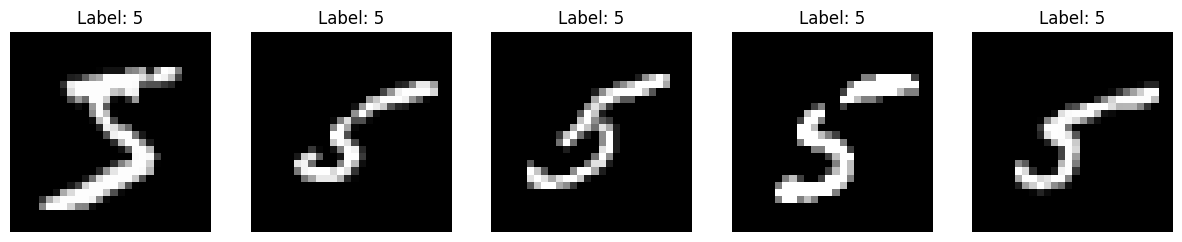

In [17]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
  image, label = filtered_dataset[i]
  image = image.squeeze().numpy() 
  axes[i].imshow(image, cmap='gray')
  axes[i].set_title(f'Label: {label}')
  axes[i].axis('off')
plt.show()

现在，我们将数据集划分为训练部分和验证部分，然后创建数据加载器（dataloader）。


In [18]:
train_dataset, validation_dataset=torch.utils.data.random_split(filtered_dataset, [0.8,0.2])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader= DataLoader(validation_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### 构建自编码器模型


对于 MNIST 数据集，一个较浅的网络架构即可取得良好的效果。


In [19]:
class ae(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)

    self.encoder = nn.Sequential( # Sequential permet de groupe une série de transformation
      nn.Linear(28 * 28, 512), 
      nn.ReLU(),
      nn.Linear(512, 256),
      nn.ReLU(),
      nn.Linear(256, 128),
      nn.ReLU(),
    )
    self.decoder = nn.Sequential(
      nn.Linear(128, 256),
      nn.ReLU(),
      nn.Linear(256, 512),
      nn.ReLU(),
      nn.Linear(512, 28 * 28),
      nn.Sigmoid()
    )
  
  def forward(self,x):
    x=x.view(-1,28*28) 
    x = self.encoder(x)
    x = self.decoder(x)
    recons=x.view(-1,28,28)
    return recons

In [20]:
model = ae()
print(model)
print("Nombre de paramètres", sum(p.numel() for p in model.parameters()))

ae(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)
Nombre de paramètres 1132944


### 模型训练


我们使用均方误差损失（MSELoss）作为损失函数，其定义为：
$\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2$
其中，$N$ 是图像中的像素总数，$y_i$ 是原始图像中第 $i$ 个像素的值，$\hat{y}_i$ 是重建图像中第 $i$ 个像素的值。
这是一种经典的重建质量评估方法。


In [21]:
criterion = nn.MSELoss()
epochs=10
learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [22]:
for i in range(epochs):
  loss_train=0
  for images, _ in train_loader:
    recons=model(images)
    loss=criterion(recons,images)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train+=loss   
  if i % 1 == 0:
    print(f"step {i} train loss {loss_train/len(train_loader)}")
  loss_val=0    
  for images, _ in val_loader:
    with torch.no_grad():
      recons=model(images)
      loss=criterion(recons,images)
      loss_val+=loss 
  if i % 1 == 0:
    print(f"step {i} val loss {loss_val/len(val_loader)}")

step 0 train loss 0.08228749781847
step 0 val loss 0.06261523813009262
step 1 train loss 0.06122465804219246
step 1 val loss 0.06214689463376999
step 2 train loss 0.06105153635144234
step 2 val loss 0.06189680099487305
step 3 train loss 0.06086035445332527
step 3 val loss 0.06180128455162048
step 4 train loss 0.0608210563659668
step 4 val loss 0.06169722229242325
step 5 train loss 0.06080913543701172
step 5 val loss 0.061976321041584015
step 6 train loss 0.060783520340919495
step 6 val loss 0.06190618872642517
step 7 train loss 0.06072703003883362
step 7 val loss 0.06161761283874512
step 8 train loss 0.06068740040063858
step 8 val loss 0.061624933034181595
step 9 train loss 0.060728199779987335
step 9 val loss 0.061608292162418365


现在，我们来看测试集中图像的重建结果。


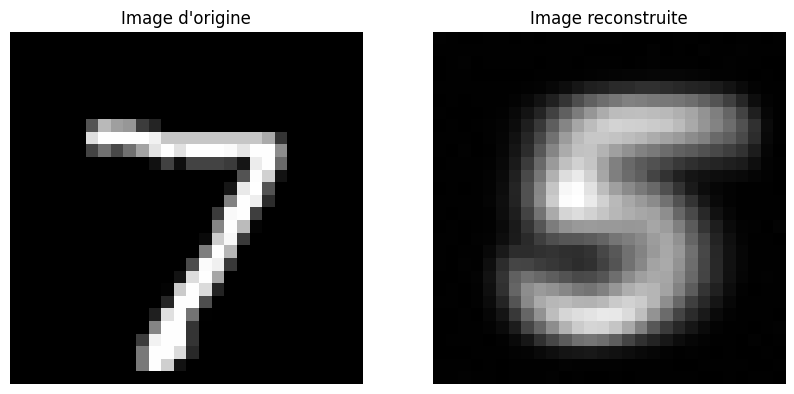

difference :  0.0687035545706749


In [23]:
images,_=next(iter(test_loader))

#Isolons un élément 
image=images[0].unsqueeze(0)
with torch.no_grad():
  recons=model(image)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Image d'origine
axs[0].imshow(image[0].squeeze().cpu().numpy(), cmap='gray')
axs[0].set_title('Image d\'origine')
axs[0].axis('off')

# Image reconstruite
axs[1].imshow(recons[0].squeeze().cpu().numpy(), cmap='gray')
axs[1].set_title('Image reconstruite')
axs[1].axis('off')
plt.show()
print("difference : ", criterion(image,recons).item())

我们发现数字“7”的重建效果非常差，这表明它是一个异常样本。
